## Projeto do compensador atraso de fase (LAG)

### Objetivo
Reduzir o erro estacionário com leve alteração da resposta transitória (deixando-a mais lenta)

### Características
- Reduz o erro 
- Adiciona um pólo e um zero, ambos no SPE (eixo real)
- O pólo deve ser pequeno, e o zero deve estar a esquerda do pólo

### Função de Transferência

$C(s) = K \frac{1 + sT}{1 + s\alpha T} , \alpha > 0$

### Exercício  (SC_Cap6_01, exercício 02, página 04)

Projete um controlador em atraso para um sistema de controle com realimentação negativa cujas funções de transferência são dadas abaixo.


$G(s) = \frac{5}{0,2s+1}$
$H(s) = \frac{0,01}{0,04s+1}$


Deseja-se obter um erro de regime permanente inferior a 2%, margem de ganho MG > 2, e margem de fase MF > 30°



In [1]:
# Bibliotecas necessárias
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import SCFuncoes

In [2]:
# Requisitos do projeto
erro_desejado = 2/100
MG_desejada = 2
MF_desejada = 30

def testar_requisitos(erro, MF, MG):
  req_atendidos = True
  if erro <= erro_desejado:
    print(f"O requisito de e(inf) <= {erro_desejado} foi atendido: e(inf) = {erro:.2f}%")
  else:
    print(f"O requisito de e(inf) <= {erro_desejado} NÃO foi atendido: e(inf) = {erro:.2f}%")
    req_atendidos = False
    
  if MF > MF_desejada:
    print(f"O requisito de MF > {MF_desejada} foi atendido: MF = {MF:.2f} rad/s")
  else:
    print(f"O requisito de MF > {MF_desejada} NÃO foi atendido: MF = {MF:.2f} rad/s")
    req_atendidos = False

  if MG > MG_desejada:
    print(f"O requisito de MG > {MG_desejada} foi atendido: MG = {MG:.2f} dB")
  else:
    print(f"O requisito de MG > {MG_desejada} NÃO foi atendido: MG = {MG:.2f} dB")
    req_atendidos = False
    
  return req_atendidos

O primeiro passo é verificar os valores dos parâmetros do sistema sem compensação, para verificar quais (e como) devem ser corrigidos para atender os requisitos de projeto.

##### Erro em regime permanente

Em regime permanente $\omega \to 0$, e a equação do erro é $e(\infty)\% = \frac{100\%}{1 + K \cdot G(0) \cdot H(0)}$

In [3]:
s, w = sp.symbols('s w', real=True)
G_s = 5 / (0.2 * s + 1)
H_s = 0.01 / (0.04 * s + 1)

# s = jw (domínio da frequência)
jw = sp.I * w
G_jw = G_s.subs(s, jw)
H_jw = H_s.subs(s, jw)

# Em regime permanente temos w -> 0
G_0 = G_jw.subs(w, 0)
H_0 = H_jw.subs(w, 0)

# Para esse projeto, o erro deve ser inferior a 5%
K_minimo = ((1 / erro_desejado) - 1) / (G_0*H_0) # valor mínimo de K para que o erro seja inferior a 5%

print(f"Para e(∞) < {erro_desejado}, K > {K_minimo.evalf():.2f}")

Para e(∞) < 0.02, K > 980.00


Tendo o valor de K para que o sistema opere com erro de 2%, deve-se plotar o diagrama de bode e determinar as margens de fase e de ganho (ainda para o sistema sem compensação)

- O diagrama de blode é feito a partir da FTMA $L(s) = KC(s)G(s)H(s)$

array([[list([<matplotlib.lines.Line2D object at 0x7dd1a14daef0>])],
       [list([<matplotlib.lines.Line2D object at 0x7dd1a14db190>])]],
      dtype=object)

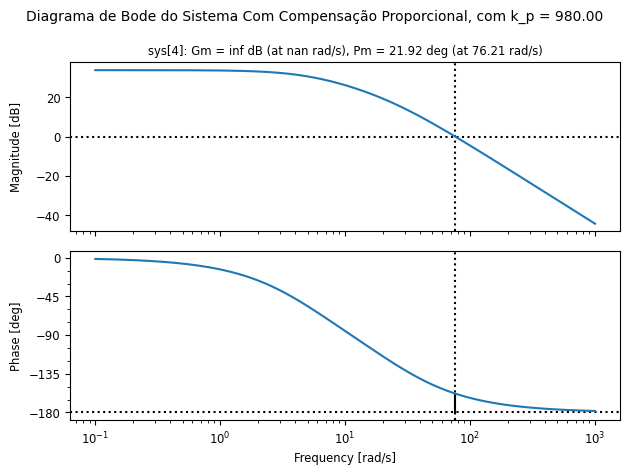

In [4]:
G_s = ctrl.tf([5],[0.2, 1])
H_s = ctrl.tf([0.01],[0.04, 1])

L_s = float(K_minimo) * G_s * H_s

# Plotar o diagrama de bode
w = np.logspace(-1, 3, 100000)
titulo = f"Diagrama de Bode do Sistema Com Compensação Proporcional, com k_p = {K_minimo:.2f}"
ctrl.bode_plot(L_s, w, dB=True, Hz=False, deg=True, display_margins=True, title=titulo)

In [5]:
gm, pm, sm, wpc, wgc, wms = ctrl.stability_margins(L_s)
# gm (float or array_like) – Gain margin
# pm (float or array_like) – Phase margin
# sm (float or array_like) – Stability margin, the minimum distance from the Nyquist plot to -1
# wpc (float or array_like) – Phase crossover frequency (where phase crosses -180 degrees), which is associated with the gain margin.
# wgc (float or array_like) – Gain crossover frequency (where gain crosses 1), which is associated with the phase margin.
# wms (float or array_like) – Stability margin frequency (where Nyquist plot is closest to -1)

print(f"Para o sistema com compensação tipo P, com k_p = {K_minimo.evalf():.2f}, temos que:")
print(f"- A frequência de ganho 0dB é {wgc:.0f} rad/s.")
print(f"- A fase na frequência de ganho 0 dB é {pm - 180:.2f} graus.")
print(f"- A margem de ganho é {gm:.0f} dB.")
print(f"- A frequência de fase -180° é {wpc:.0f} rad/s.")
print(f"- O ganho na frequência de fase -180° é {0 - (20 * np.log10(gm)):.2f} dB.")
print(f"- A margem de fase é {pm:.0f} dB.")

Para o sistema com compensação tipo P, com k_p = 980.00, temos que:
- A frequência de ganho 0dB é 76 rad/s.
- A fase na frequência de ganho 0 dB é -158.08 graus.
- A margem de ganho é inf dB.
- A frequência de fase -180° é nan rad/s.
- O ganho na frequência de fase -180° é -inf dB.
- A margem de fase é 22 dB.


Verificar se o compensador proporcional foi suficiente para atender os requisitos do projeto

In [6]:
# Para esse projeto, o erro deve ser inferior a 5%
erro = 1 / (1 + (K_minimo * G_0 * H_0))
resultado = testar_requisitos(erro, pm, gm)

if resultado:
  print(f'\nO compensador proporcional com k_p = {K_minimo:.2f} foi suficiente para atender os requisitos do projeto')
else:
  print(f'\nO compensador proporcional com k_p = {K_minimo:.2f} NÃO foi suficiente para atender os requisitos do projeto')

O requisito de e(inf) <= 0.02 foi atendido: e(inf) = 0.02%
O requisito de MF > 30 NÃO foi atendido: MF = 21.92 rad/s
O requisito de MG > 2 foi atendido: MG = inf dB

O compensador proporcional com k_p = 980.00 NÃO foi suficiente para atender os requisitos do projeto
